# Bayesian signal de-blending with Gaussian Random Fields

Florent Leclercq,<br/>
Institut d'Astrophysique de Paris,<br/>
florent.leclercq@iap.fr

In [1]:
import numpy as np
import scipy.linalg
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
np.random.seed(123456)

In [2]:
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': r"\usepackage{amsmath}\usepackage{upgreek}"})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 15})
dir="./plots/Wiener_filter_deblending/"
!mkdir -p $dir

In [3]:
N=1000
epsilon=0.000000000001

## Setup signal covariance

In [4]:
# Signal 1: a Lorentzian distribution in Fourier space
gamma=2.5
def covar1(k, gamma=gamma):
    return 1./(np.pi*gamma*(1+k*k/(gamma*gamma)))
signalcovar1=np.array([covar1(k) for k in range(N)])

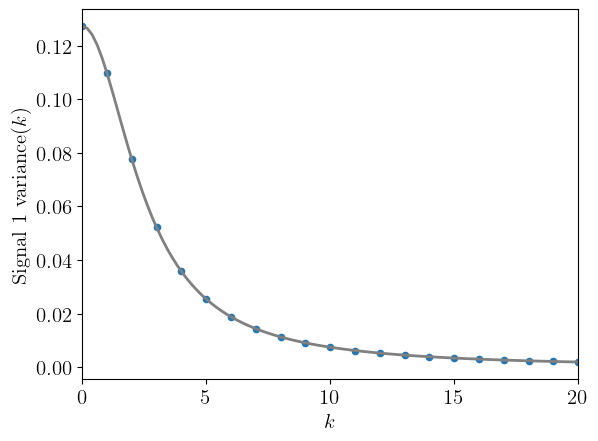

In [5]:
plt.xlim(0, 20)
plt.plot(np.linspace(0, 20, 100), covar1(np.linspace(0, 20, 100)), color='grey')
plt.scatter(np.arange(21),signalcovar1[:21],s=20)
plt.xlabel("$k$")
plt.ylabel("Signal 1 variance($k$)")
plt.savefig(dir+'signal1_variance.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'signal1_variance.png',dpi=300,bbox_inches="tight")
plt.show()

In [6]:
# A diagonal covariance matrix in Fourier space
Cx1x1_Fourier=np.diagflat(signalcovar1)
Cx1x1=np.fft.ifft(np.fft.fft(Cx1x1_Fourier).T).T.real
sqrtCx1x1_Fourier=np.diagflat(np.sqrt(signalcovar1))
sqrtCx1x1=np.fft.ifft(np.fft.fft(sqrtCx1x1_Fourier).T).T.real
sqrtCx1x1=sqrtCx1x1.real

In [7]:
# Signal 2: a model where the correlation between scales increases with x, in real space
def covar2(i,j):
    return 5e-4*np.exp(-np.power(np.abs(i-j),1.2)/50.)
Cx2x2=np.array([[covar2(i,j) for i in range(N)] for j in range(N)])
sqrtCx2x2=scipy.linalg.sqrtm(Cx2x2)
sqrtCx2x2=sqrtCx2x2.real

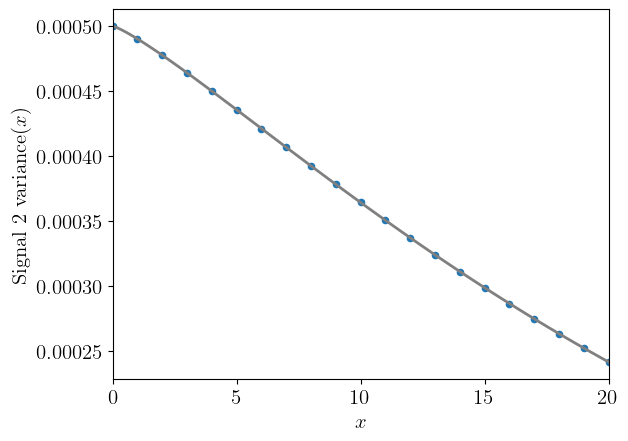

In [8]:
plt.xlim(0, 20)
plt.plot(np.linspace(0, 20, 100), [covar2(0,x) for x in np.linspace(0, 20, 100)], color='grey')
plt.scatter(np.arange(21),Cx2x2[0][:21],s=20)
plt.xlabel("$x$")
plt.ylabel("Signal 2 variance($x$)")
plt.savefig(dir+'signal2_variance.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'signal2_variance.png',dpi=300,bbox_inches="tight")
plt.show()

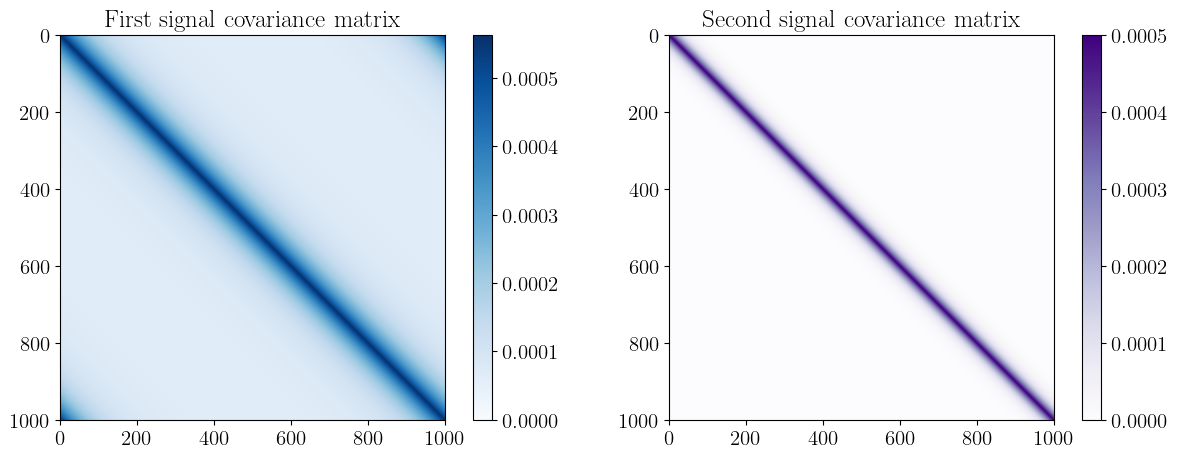

In [9]:
# Create a custom RdBu colormap with truncated red and centered around zero
cmap = plt.get_cmap('RdBu')
blue_part = cmap(np.linspace(0., 0.5, 128))
red_part = cmap(np.linspace(0.5, 1., 128))
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom RdBu', np.vstack((blue_part, red_part)))
norm = mcolors.TwoSlopeNorm(vcenter=0.)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
f.subplots_adjust(wspace=0.1)
ax1.set_xlim(0, N)
ax1.set_ylim(N, 0)
im1 = ax1.imshow(Cx1x1, cmap='Blues', vmin=0.)
ax1.set_title("First signal covariance matrix")
ax1.set_aspect('equal')
cbar1 = f.colorbar(im1, ax=ax1)

ax2.set_xlim(0, N)
ax2.set_ylim(N, 0)
im2 = ax2.imshow(Cx2x2, cmap='Purples', vmin=0.)
ax2.set_title("Second signal covariance matrix")
ax2.set_aspect('equal')
cbar2 = f.colorbar(im2, ax=ax2)

plt.savefig(dir+'signal_covariance_matrices.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'signal_covariance_matrices.png',dpi=300,bbox_inches="tight")
plt.show()

## 1-Easy case: non-blended regions are not masked 

### Setup noise covariance

\begin{equation}
n = \begin{bmatrix} n_1 \\ n_{12} \\ n_2 \end{bmatrix}
\end{equation}

\begin{equation}
C_{nn} = \begin{bmatrix} C_{n_1n_1} & 0 & 0 \\ 0 & C_{n_{12}n_{12}} & 0 \\ 0 & 0 & C_{n_2n_2} \end{bmatrix}
\end{equation}

In [10]:
noiselevel=0.00005
noisepower=noiselevel*np.ones(N)
Cn1n1=Cn12n12=Cn2n2=np.diagflat(noisepower)
sqrtCn1n1=sqrtCn12n12=sqrtCn2n2=np.diagflat(np.sqrt(noisepower))
Cnn=np.bmat([[Cn1n1,          np.zeros((N,N)), np.zeros((N,N))],\
            [np.zeros((N,N)), Cn12n12,           np.zeros((N,N))],\
            [np.zeros((N,N)), np.zeros((N,N)), Cn2n2]])

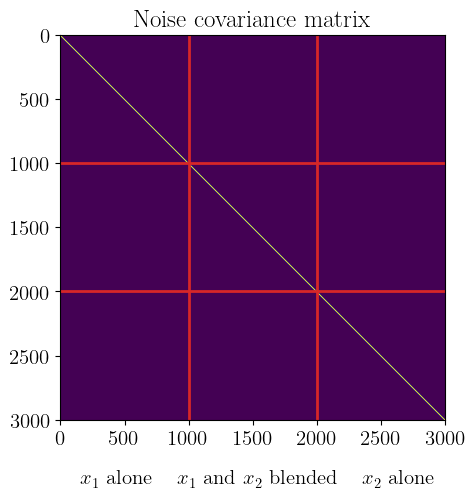

In [11]:
plt.figure(figsize=(5,5))
plt.xlim(0, 3*N)
plt.ylim(3*N, 0)
plt.imshow(Cnn, cmap='viridis', vmin=0., vmax=0.1*noiselevel)
plt.plot([0,3000-1],[1000-1,1000-1],color='C3')
plt.plot([0,3000-1],[2000-1,2000-1],color='C3')
plt.plot([1000-1,1000-1],[0,3000-1],color='C3')
plt.plot([2000-1,2000-1],[0,3000-1],color='C3')
plt.text(150,3500,s="$x_1$ alone")
plt.text(910,3500,s="$x_1$ and $x_2$ blended")
plt.text(2350,3500,s="$x_2$ alone")
plt.title("Noise covariance matrix")
plt.savefig(dir+'noise_covariance_matrix_case1.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'noise_covariance_matrix_case1.png',dpi=300,bbox_inches="tight")
plt.show()

### Generate mock data

In [12]:
# The truth
x1=sqrtCx1x1.dot(np.random.normal(0.,1.,N))
x2=sqrtCx2x2.dot(np.random.normal(0.,1.,N))

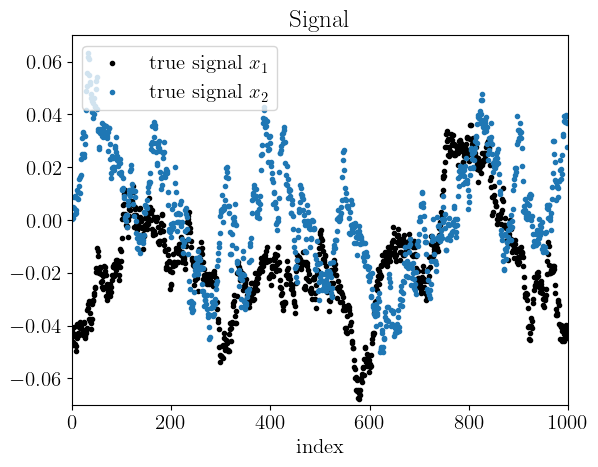

In [13]:
plt.xlim(0,N)
plt.ylim(-0.07,0.07)
plt.xlabel("index")
plt.scatter(np.arange(N),x1,marker='.',color='black',label="true signal $x_1$")
plt.scatter(np.arange(N),x2,marker='.',color='C0',label="true signal $x_2$")
plt.title("Signal")
plt.legend(loc='upper left')
plt.savefig(dir+'signals.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'signals.png',dpi=300,bbox_inches="tight")
plt.show()

In [14]:
# The noise
n1=sqrtCn1n1.dot(np.random.normal(0.,1.,N))
n12=sqrtCn12n12.dot(np.random.normal(0.,1.,N))
n2=sqrtCn2n2.dot(np.random.normal(0.,1.,N))

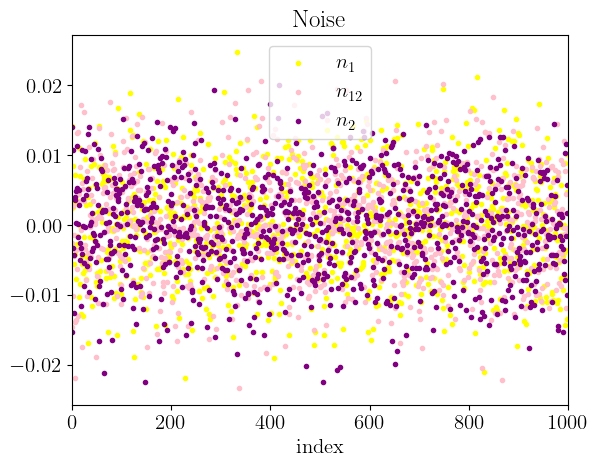

In [15]:
plt.xlim(0,N)
plt.xlabel("index")
plt.scatter(np.arange(N),n1,marker='.',color='yellow',label='$n_1$')
plt.scatter(np.arange(N),n12,marker='.',color='pink',label='$n_{12}$')
plt.scatter(np.arange(N),n2,marker='.',color='purple',label='$n_2$')
plt.title("Noise")
plt.legend(loc='best')
plt.savefig(dir+'noise_case1.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'noise_case1.png',dpi=300,bbox_inches="tight")
plt.show()

The data model:
\begin{equation}
d = \begin{bmatrix} d_1 \\ d_{12} \\ d_2 \end{bmatrix} =\
    \begin{bmatrix} x_1+n_1 \\ x_1+x_2+n_{12}  \\ x_2+n_2 \end{bmatrix}
\end{equation}

In [16]:
d1=x1+n1
d12=x1+x2+n12
d2=x2+n2

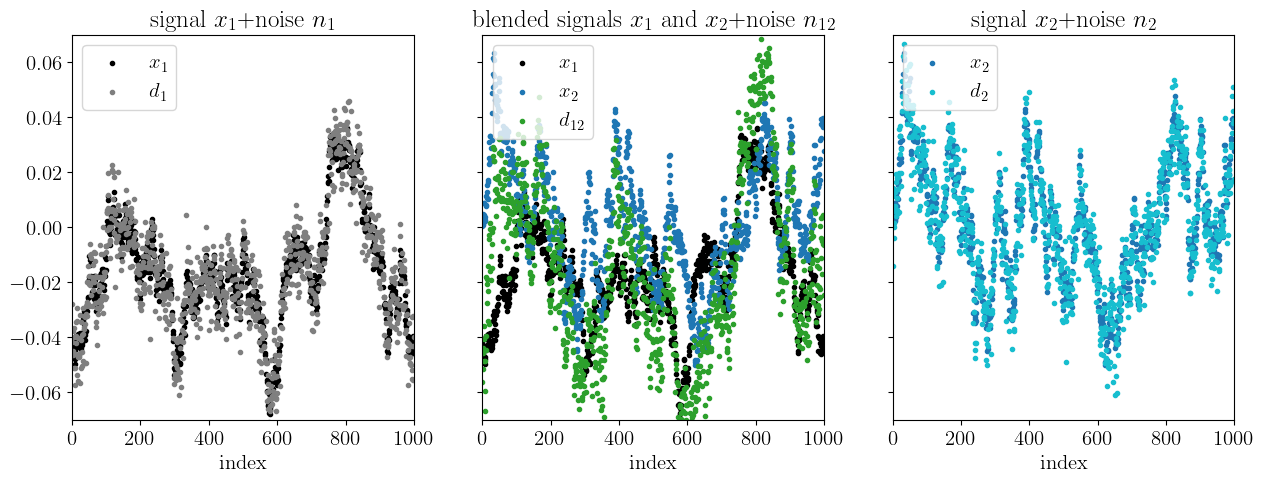

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))
ax1.set_xlim(0,N)
ax1.set_ylim(-0.07,0.07)
ax1.set_xlabel("index")
ax1.scatter(np.arange(N),x1,marker='.',color='black',label='$x_1$')
ax1.scatter(np.arange(N),d1,marker='.',color='C7',label='$d_1$')
ax1.set_title("signal $x_1$+noise $n_1$")
ax1.legend(loc='upper left')
ax2.set_xlim(0,N)
ax2.set_ylim(-0.07,0.07)
ax2.set_xlabel("index")
ax2.set_ylim(d2.min()*1.1,d2.max()*1.1)
ax2.scatter(np.arange(N),x1,marker='.',color='black',label='$x_1$')
ax2.scatter(np.arange(N),x2,marker='.',color='C0',label='$x_2$')
ax2.scatter(np.arange(N),d12,marker='.',color='C2',label='$d_{12}$')
ax2.set_title("blended signals $x_1$ and $x_2$+noise $n_{12}$")
ax2.legend(loc='upper left')
ax3.set_xlim(0,N)
ax3.set_ylim(-0.07,0.07)
ax3.set_xlabel("index")
ax3.scatter(np.arange(N),x2,marker='.',color='C0',label='$x_2$')
ax3.scatter(np.arange(N),d2,marker='.',color='C9',label='$d_2$')
ax3.set_title("signal $x_2$+noise $n_2$")
ax3.legend(loc='upper left')
plt.savefig(dir+'data_case1.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'data_case1.png',dpi=300,bbox_inches="tight")
plt.show()

### Setup Wiener de-blender

Assumptions:
\begin{equation}
C_{x_1x_2} = C_{x_1n_1} = C_{x_1n_{12}} = C_{x_2n_{12}} = C_{x_2n_2} = 0
\end{equation}

Then:
\begin{align}
C_{x_1d} & = & \begin{bmatrix} C_{x_1x_1} & C_{x_1x_1} & 0 \end{bmatrix}; \quad C_{dx_1} = C_{x_1d}^\intercal\\
C_{x_2d} & = & \begin{bmatrix} 0 & C_{x_2x_2} & C_{x_2x_2} \end{bmatrix}; \quad C_{dx_2} = C_{x_2d}^\intercal \\
C_{dd} & = & \begin{bmatrix} C_{x_1x_1}+C_{n_1n_1} & C_{x_1x_1} & 0\\
C_{x_1x_1} & C_{x_1x_1}+C_{x_2x_2}+C_{n_{12}n_{12}} & C_{x_2x_2}\\
0 & C_{x_2x_2} & C_{x_2x_2}+C_{n_2n_2}
\end{bmatrix}
\end{align}

In [18]:
d=np.bmat([[d1,d12,d2]]).T
Cx1d=np.bmat([[Cx1x1, Cx1x1, np.zeros((N,N))]])
Cdx1=Cx1d.T
Cx2d=np.bmat([[np.zeros((N,N)), Cx2x2, Cx2x2]])
Cdx2=Cx2d.T
Cdd=np.bmat([[Cx1x1+Cn1n1,     Cx1x1,             np.zeros((N,N))],\
             [Cx1x1,           Cx1x1+Cx2x2+Cn12n12, Cx2x2],\
             [np.zeros((N,N)), Cx2x2,             Cx2x2+Cn2n2]])
invCdd=np.linalg.inv(Cdd)

### Perform signal reconstruction

\begin{align}
\mu_{x_1|d} & = & C_{x_1d}C_{dd}^{-1}d\\
\mu_{x_2|d} & = & C_{x_2d}C_{dd}^{-1}d
\end{align}

In [19]:
x1WF=Cx1d.dot(invCdd).dot(d)
x2WF=Cx2d.dot(invCdd).dot(d)
x1WF=np.squeeze(np.asarray(x1WF))
x2WF=np.squeeze(np.asarray(x2WF))

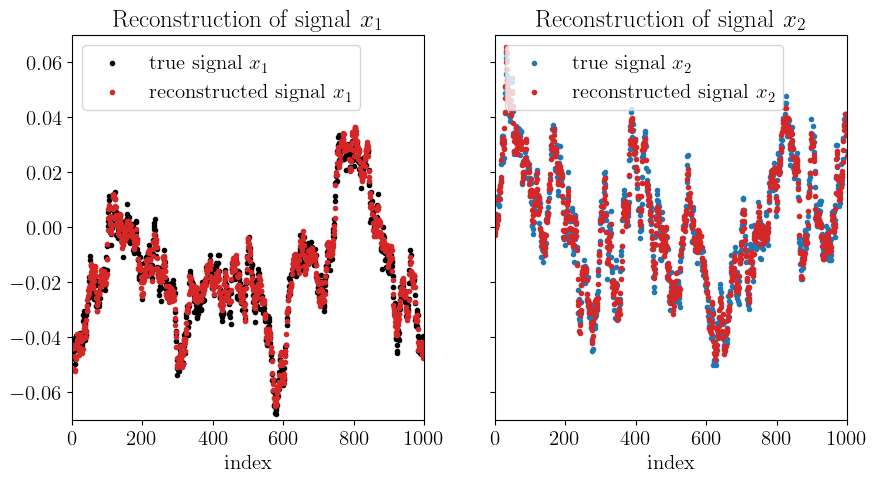

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax1.set_xlim(0,N)
ax1.set_ylim(-0.07,0.07)
ax1.set_xlabel("index")
ax1.scatter(np.arange(N),x1,marker='.',color='black',label="true signal $x_1$")
ax1.scatter(np.arange(N),x1WF,marker='.',color='C3',label="reconstructed signal $x_1$")
ax1.set_title("Reconstruction of signal $x_1$")
ax1.legend(loc='upper left')
ax2.set_xlim(0,N)
ax2.set_ylim(-0.07,0.07)
ax2.set_xlabel("index")
ax2.scatter(np.arange(N),x2,marker='.',color='C0',label="true signal $x_2$")
ax2.scatter(np.arange(N),x2WF,marker='.',color='C3',label="reconstructed signal $x_2$")
ax2.set_title("Reconstruction of signal $x_2$")
ax2.legend(loc='upper left')
plt.savefig(dir+'reconstructed_signals_case1.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'reconstructed_signals_case1.png',dpi=300,bbox_inches="tight")
plt.show()

\begin{align}
C_{x_1|d} & = & C_{x_1x_1} - C_{x_1d}C_{dd}^{-1}C_{dx_1}\\
C_{x_2|d} & = & C_{x_2x_2} - C_{x_2d}C_{dd}^{-1}C_{dx_2}\\
\end{align}

### Generate constrained realizations

\begin{align}
C_{x_1|d} & = & C_{x_1x_1} - C_{x_1d}C_{dd}^{-1}C_{dx_1}\\
C_{x_2|d} & = & C_{x_2x_2} - C_{x_2d}C_{dd}^{-1}C_{dx_2}\\
\end{align}

In [21]:
Cx1WF=Cx1x1-Cx1d.dot(invCdd).dot(Cdx1)
Cx2WF=Cx2x2-Cx2d.dot(invCdd).dot(Cdx2)
sqrtCx1WF=scipy.linalg.sqrtm(Cx1WF)
sqrtCx1WF=sqrtCx1WF.real
sqrtCx2WF=scipy.linalg.sqrtm(Cx2WF)
sqrtCx2WF=sqrtCx2WF.real

In [22]:
x1cr1=sqrtCx1WF.dot(np.random.normal(0.,1.,N))+x1WF
x1cr2=sqrtCx1WF.dot(np.random.normal(0.,1.,N))+x1WF
x1cr3=sqrtCx1WF.dot(np.random.normal(0.,1.,N))+x1WF
x2cr1=sqrtCx2WF.dot(np.random.normal(0.,1.,N))+x2WF
x2cr2=sqrtCx2WF.dot(np.random.normal(0.,1.,N))+x2WF
x2cr3=sqrtCx2WF.dot(np.random.normal(0.,1.,N))+x2WF

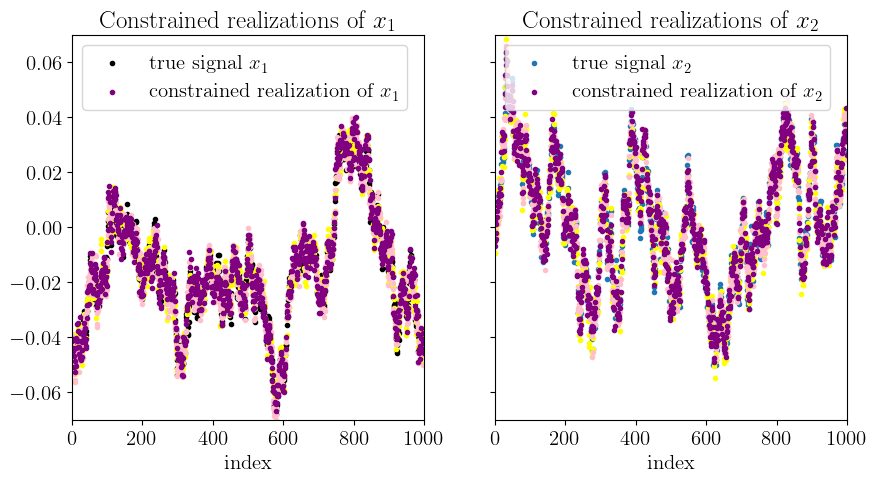

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax1.set_xlim(0,N)
ax1.set_ylim(-0.07,0.07)
ax1.set_xlabel("index")
ax1.scatter(np.arange(N),x1,marker='.',color='black',label="true signal $x_1$")
ax1.scatter(np.arange(N),x1cr1,marker='.',color='yellow')
ax1.scatter(np.arange(N),x1cr2,marker='.',color='pink')
ax1.scatter(np.arange(N),x1cr3,marker='.',color='purple',label="constrained realization of $x_1$")
ax1.set_title("Constrained realizations of $x_1$")
ax1.legend(loc='upper left')
ax2.set_xlim(0,N)
ax2.set_xlabel("index")
ax2.set_ylim(-0.07,0.07)
ax2.scatter(np.arange(N),x2,marker='.',color='C0',label="true signal $x_2$")
ax2.scatter(np.arange(N),x2cr1,marker='.',color='yellow')
ax2.scatter(np.arange(N),x2cr2,marker='.',color='pink')
ax2.scatter(np.arange(N),x2cr3,marker='.',color='purple',label="constrained realization of $x_2$")
ax2.set_title("Constrained realizations of $x_2$")
ax2.legend(loc='upper left')
plt.savefig(dir+'constrained_realizations_case1.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'constrained_realizations_case1.png',dpi=300,bbox_inches="tight")
plt.show()

## 2-Difficult case: non-blended regions are masked

### Setup noise covariance

\begin{equation}
n = \begin{bmatrix} n_1 \\ n_{12} \\ n_3 \end{bmatrix}
\end{equation}

\begin{equation}
C_{nn} = \begin{bmatrix} C_{n_1n_1} & 0 & 0 \\ 0 & C_{n_{12}n_{12}} & 0 \\ 0 & 0 & C_{n_2n_2} \end{bmatrix}
\end{equation}

In [24]:
mask=np.ones(3*N)
mask[0:N]=0.
mask[N:2*N]=1.
mask[2*N:3*N]=0.

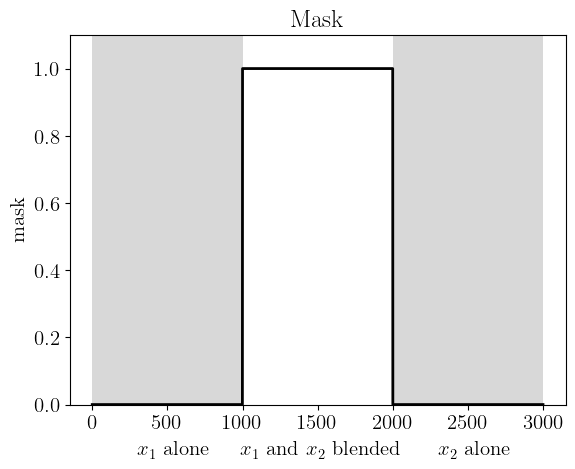

In [25]:
plt.ylim(0,1.1)
plt.ylabel("mask")
plt.plot(np.arange(3*N), mask, color='black')
plt.fill_between([0,N],0.,1.1,facecolor='grey',alpha=0.3, linewidth=0.)
plt.fill_between([2*N,3*N],0.,1.1,facecolor='grey',alpha=0.3, linewidth=0.)
plt.text(300,-0.15,s="$x_1$ alone")
plt.text(980,-0.15,s="$x_1$ and $x_2$ blended")
plt.text(2300,-0.15,s="$x_2$ alone")
plt.title("Mask")
plt.savefig(dir+'mask.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'mask.png',dpi=300,bbox_inches="tight")
plt.show()

In [26]:
noisepower=0.00005*np.ones(N)
Cn2n2=np.diagflat(noisepower)
sqrtCn12n12=np.diagflat(np.sqrt(noisepower))
Cn1n1=Cn2n2=np.diagflat(np.ones(N))
sqrtCn1n1=sqrtCn2n2=np.diagflat(np.ones(N))
Cnn=np.bmat([[Cn1n1,          np.zeros((N,N)), np.zeros((N,N))],\
            [np.zeros((N,N)), Cn12n12,           np.zeros((N,N))],\
            [np.zeros((N,N)), np.zeros((N,N)), Cn2n2]])

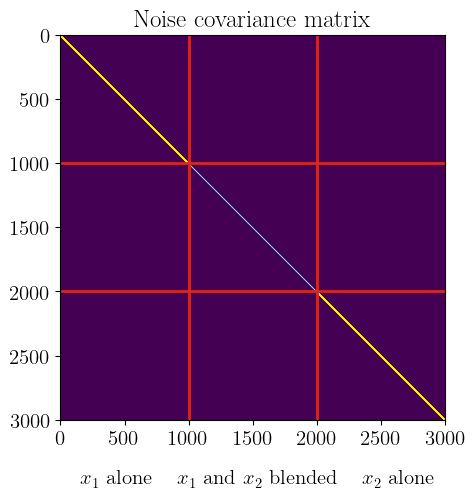

In [27]:
plt.figure(figsize=(5,5))
plt.xlim(0, 3*N)
plt.ylim(3*N, 0)
plt.imshow(Cnn, cmap='viridis', vmin=0., vmax=0.1*noiselevel)
plt.plot([0,3000-1],[1000-1,1000-1],color='C3')
plt.plot([0,3000-1],[2000-1,2000-1],color='C3')
plt.plot([1000-1,1000-1],[0,3000-1],color='C3')
plt.plot([2000-1,2000-1],[0,3000-1],color='C3')
plt.text(150,3500,s="$x_1$ alone")
plt.text(910,3500,s="$x_1$ and $x_2$ blended")
plt.text(2350,3500,s="$x_2$ alone")
plt.title("Noise covariance matrix")
plt.savefig(dir+'noise_covariance_matrix_case2.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'noise_covariance_matrix_case2.png',dpi=300,bbox_inches="tight")
plt.show()

### Generate mock data

In [28]:
# The noise, with infinite variance in masked regions
n1=sqrtCn1n1.dot(np.random.normal(0.,1.,N))
n2=sqrtCn2n2.dot(np.random.normal(0.,1.,N))

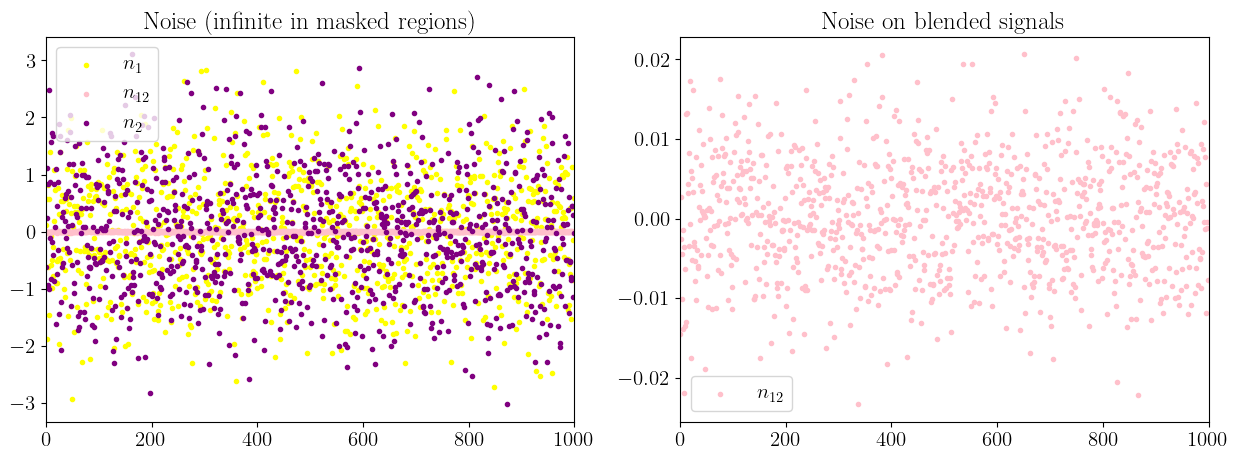

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_xlim(0,N)
ax1.scatter(np.arange(N),n1,marker='.',color='yellow',label='$n_1$')
ax1.scatter(np.arange(N),n12,marker='.',color='pink',label='$n_{12}$')
ax1.scatter(np.arange(N),n2,marker='.',color='purple',label='$n_2$')
ax1.set_title("Noise (infinite in masked regions)")
ax1.legend(loc='best')
ax2.set_xlim(0,N)
ax2.scatter(np.arange(N),n12,marker='.',color='pink',label='$n_{12}$')
ax2.set_title("Noise on blended signals")
ax2.legend(loc='best')
plt.savefig(dir+'noise_case2.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'noise_case2.png',dpi=300,bbox_inches="tight")
plt.show()

The data model:
\begin{equation}
d = \begin{bmatrix} d_1 \\ d_{12} \\ d_2 \end{bmatrix} =\
    \begin{bmatrix} x_1+n_1 \\ x_1+x_2+n_{12}  \\ x_2+n_2 \end{bmatrix}
\end{equation}

In [30]:
d1=x1+n1
d2=x2+n2

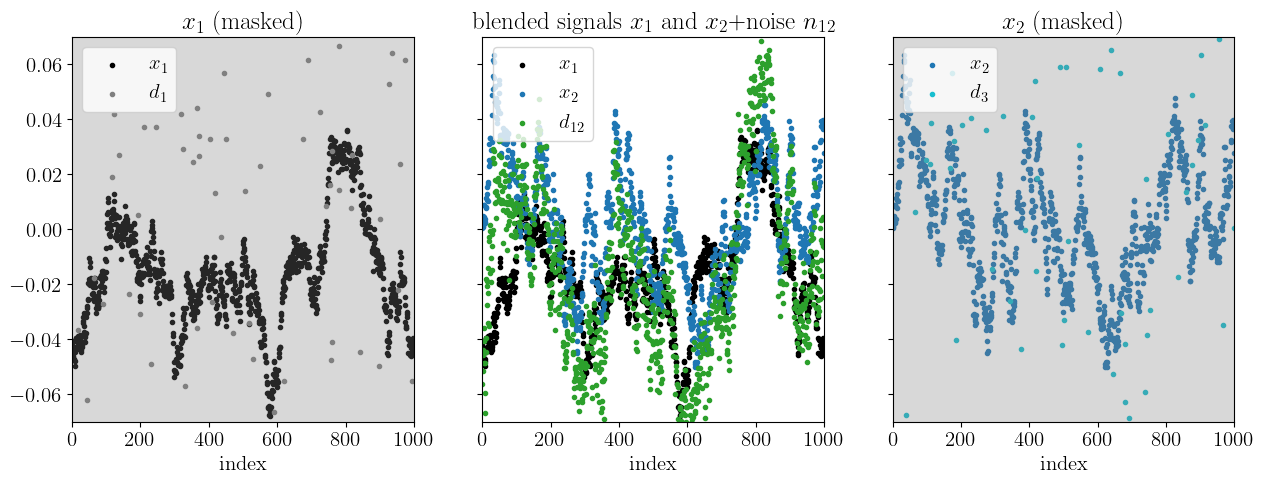

In [31]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))
ax1.set_xlim(0,N)
ax1.set_ylim(-0.07,0.07)
ax1.set_xlabel("index")
ax1.scatter(np.arange(N),x1,marker='.',color='black',label='$x_1$')
ax1.scatter(np.arange(N),d1,marker='.',color='grey',label='$d_1$')
ylim=ax1.get_ylim()
ax1.fill_between([0,N],ylim[0],ylim[1],facecolor='grey',alpha=0.3, linewidth=0.)
ax1.set_title("$x_1$ (masked)")
ax1.legend(loc='upper left')
ax2.set_xlim(0,N)
ax2.set_ylim(-0.07,0.07)
ax2.set_xlabel("index")
ax2.set_ylim(d12.min()*1.1,d12.max()*1.1)
ax2.scatter(np.arange(N),x1,marker='.',color='black',label='$x_1$')
ax2.scatter(np.arange(N),x2,marker='.',color='C0',label='$x_2$')
ax2.scatter(np.arange(N),d12,marker='.',color='C2',label='$d_{12}$')
ax2.set_title("blended signals $x_1$ and $x_2$+noise $n_{12}$")
ax2.legend(loc='upper left')
ax3.set_xlim(0,N)
ax3.set_ylim(-0.07,0.07)
ax3.set_xlabel("index")
ax3.scatter(np.arange(N),x2,marker='.',color='C0',label='$x_2$')
ax3.scatter(np.arange(N),d2,marker='.',color='C9',label='$d_3$')
ylim=ax3.get_ylim()
ax3.fill_between([0,N],ylim[0],ylim[1],facecolor='grey',alpha=0.3, linewidth=0.)
ax3.set_title("$x_2$ (masked)")
ax3.legend(loc='upper left')
plt.savefig(dir+'data_case2.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'data_case2.png',dpi=300,bbox_inches="tight")
plt.show()

### Setup Wiener de-blender

Assumptions:
\begin{equation}
C_{x_1x_2} = C_{x_1n_1} = C_{x_1n_{12}} = C_{x_2n_{12}} = C_{x_2n_2} = 0
\end{equation}

Then:
\begin{align}
C_{x_1d} & = & \begin{bmatrix} C_{x_1x_1} & C_{x_1x_1} & 0 \end{bmatrix}; \quad C_{dx_1} = C_{x_1d}^\mathrm{T}\\
C_{x_2d} & = & \begin{bmatrix} 0 & C_{x_2x_2} & C_{x_2x_2} \end{bmatrix}; \quad C_{dx_2} = C_{x_2d}^\mathrm{T} \\
C_{dd} & = & \begin{bmatrix} C_{x_1x_1}+C_{n_1n_1} & C_{x_1x_1} & 0\\
C_{x_1x_1} & C_{x_1x_1}+C_{x_2x_2}+C_{n_{12}n_{12}} & C_{x_2x_2}\\
0 & C_{x_2x_2} & C_{x_2x_2}+C_{n_2n_2}
\end{bmatrix}
\end{align}

In [32]:
d=np.bmat([[d1,d12,d2]]).T
Cx1d=np.bmat([[Cx1x1, Cx1x1, np.zeros((N,N))]])
Cdx1=Cx1d.T
Cx2d=np.bmat([[np.zeros((N,N)), Cx2x2, Cx2x2]])
Cdx2=Cx2d.T
Cdd=np.bmat([[Cx1x1+Cn1n1,     Cx1x1,             np.zeros((N,N))],\
             [Cx1x1,           Cx1x1+Cx2x2+Cn12n12, Cx2x2],\
             [np.zeros((N,N)), Cx2x2,             Cx2x2+Cn2n2]])
invCdd=np.linalg.inv(Cdd)

### Perform signal reconstruction

\begin{align}
\mu_{x_1|d} & = & C_{x_1d}C_{dd}^{-1}d\\
\mu_{x_2|d} & = & C_{x_2d}C_{dd}^{-1}d
\end{align}

In [33]:
x1WF=Cx1d.dot(invCdd).dot(d)
x2WF=Cx2d.dot(invCdd).dot(d)
x1WF=np.squeeze(np.asarray(x1WF))
x2WF=np.squeeze(np.asarray(x2WF))

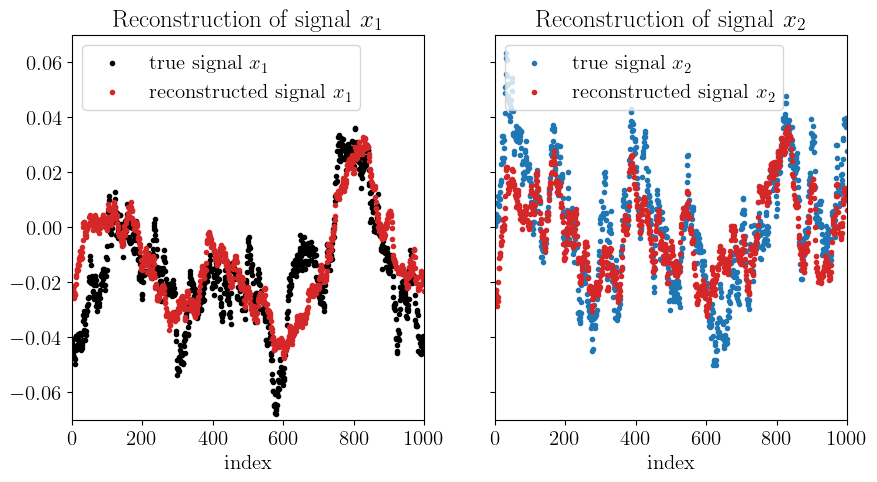

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax1.set_xlim(0,N)
ax1.set_ylim(-0.07,0.07)
ax1.set_xlabel("index")
ax1.scatter(np.arange(N),x1,marker='.',color='black',label="true signal $x_1$")
ax1.scatter(np.arange(N),x1WF,marker='.',color='C3',label="reconstructed signal $x_1$")
ax1.set_title("Reconstruction of signal $x_1$")
ax1.legend(loc='upper left')
ax2.set_xlim(0,N)
ax2.set_ylim(-0.07,0.07)
ax2.set_xlabel("index")
ax2.scatter(np.arange(N),x2,marker='.',color='C0',label="true signal $x_2$")
ax2.scatter(np.arange(N),x2WF,marker='.',color='C3',label="reconstructed signal $x_2$")
ax2.set_title("Reconstruction of signal $x_2$")
ax2.legend(loc='upper left')
plt.savefig(dir+'reconstructed_signals_case2.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'reconstructed_signals_case2.png',dpi=300,bbox_inches="tight")
plt.show()

### Generate constrained realizations

\begin{align}
C_{x_1|d} & = & C_{x_1x_1} - C_{x_1d}C_{dd}^{-1}C_{dx_1}\\
C_{x_2|d} & = & C_{x_2x_2} - C_{x_2d}C_{dd}^{-1}C_{dx_2}\\
\end{align}

In [35]:
Cx1WF=Cx1x1-Cx1d.dot(invCdd).dot(Cdx1)
Cx2WF=Cx2x2-Cx2d.dot(invCdd).dot(Cdx2)
sqrtCx1WF=scipy.linalg.sqrtm(Cx1WF)
sqrtCx1WF=sqrtCx1WF.real
sqrtCx2WF=scipy.linalg.sqrtm(Cx2WF)
sqrtCx2WF=sqrtCx2WF.real

In [36]:
x1cr1=sqrtCx1WF.dot(np.random.normal(0.,1.,N))+x1WF
x1cr2=sqrtCx1WF.dot(np.random.normal(0.,1.,N))+x1WF
x1cr3=sqrtCx1WF.dot(np.random.normal(0.,1.,N))+x1WF
x2cr1=sqrtCx2WF.dot(np.random.normal(0.,1.,N))+x2WF
x2cr2=sqrtCx2WF.dot(np.random.normal(0.,1.,N))+x2WF
x2cr3=sqrtCx2WF.dot(np.random.normal(0.,1.,N))+x2WF

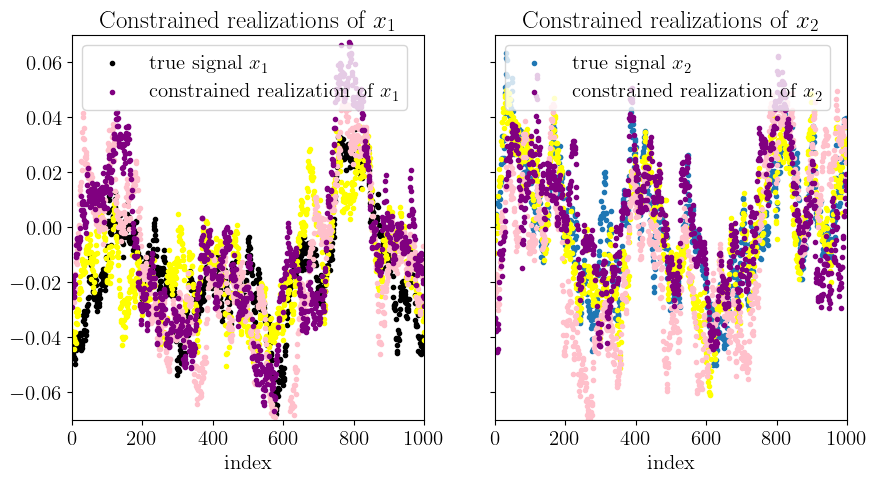

In [37]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax1.set_xlim(0,N)
ax1.set_ylim(-0.07,0.07)
ax1.set_xlabel("index")
ax1.scatter(np.arange(N),x1,marker='.',color='black',label="true signal $x_1$")
ax1.scatter(np.arange(N),x1cr1,marker='.',color='yellow')
ax1.scatter(np.arange(N),x1cr2,marker='.',color='pink')
ax1.scatter(np.arange(N),x1cr3,marker='.',color='purple',label="constrained realization of $x_1$")
ax1.set_title("Constrained realizations of $x_1$")
ax1.legend(loc='upper left')
ax2.set_xlim(0,N)
ax2.set_ylim(-0.07,0.07)
ax2.set_xlabel("index")
ax2.scatter(np.arange(N),x2,marker='.',color='C0',label="true signal $x_2$")
ax2.scatter(np.arange(N),x2cr1,marker='.',color='yellow')
ax2.scatter(np.arange(N),x2cr2,marker='.',color='pink')
ax2.scatter(np.arange(N),x2cr3,marker='.',color='purple',label="constrained realization of $x_2$")
ax2.set_title("Constrained realizations of $x_2$")
ax2.legend(loc='upper left')
plt.savefig(dir+'constrained_realizations_case2.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'constrained_realizations_case2.png',dpi=300,bbox_inches="tight")
plt.show()